In [2]:
import pandas as pd
import numpy as np
import panel as pn

pn.extension()

In [3]:
df = (
    pd.read_csv("timing.csv", header=None, names=['module', 'len_Q', 'len_T', 'n_iter', 'time'])
    .pipe(
        lambda x: x.assign(Q_p=np.log2(x.len_Q).astype(np.int64))
    )
    .pipe(
        lambda x: x.assign(T_p=np.log2(x.len_T).astype(np.int64))
    )
    .groupby(['module', 'len_Q']).filter(lambda x: len(x) >= 2)
)
df

,module,len_Q,len_T,n_iter,time,Q_p,T_p
0,sdp.pyfftw_sdp,64,64,3,0.000069,6,6
1,sdp.pyfftw_sdp,64,128,3,0.000080,6,7
2,sdp.pyfftw_sdp,64,256,3,0.000106,6,8
3,sdp.pyfftw_sdp,64,512,3,0.000146,6,9
4,sdp.pyfftw_sdp,64,1024,3,0.000215,6,10
...,...,...,...,...,...,...,...
873,sdp.scipy_oaconvolve_sdp,16777216,33554432,3,1.788871,24,25
874,sdp.scipy_oaconvolve_sdp,16777216,67108864,3,2.994278,24,26
875,sdp.scipy_oaconvolve_sdp,16777216,134217728,3,6.983685,24,27
876,sdp.scipy_oaconvolve_sdp,33554432,33554432,3,2.444229,25,25


In [4]:
def model(n=5):
    return "⭐"*n

pn.extension()

slider = pn.widgets.IntSlider(value=5, start=1, end=5)

interactive_model = pn.bind(model, n=slider)

layout = pn.Column(slider, interactive_model)

In [15]:
layout

Column
    [0] IntSlider(end=5, start=1, value=5)
    [1] ParamFunction(function, _pane=Markdown, defer_load=False)

Column
    [0] FloatSlider(end=2, value=1)
    [1] Matplotlib(Figure, dpi=96)
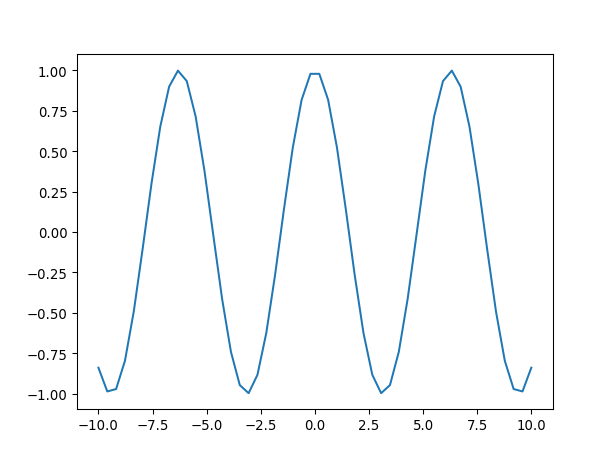

In [14]:
import numpy as np
import panel as pn
from matplotlib.figure import Figure

pn.extension()

def make_plot():
    x = np.linspace(-10, 10)
    fig = Figure()
    ax = fig.subplots()
    line, = ax.plot(x, np.cos(x))
    return fig

x = np.linspace(-10, 10)
fig = Figure()
ax = fig.subplots()
line, = ax.plot(x, np.cos(x))

# fig = make_plot()
slider = pn.widgets.FloatSlider(start=0, end=2, value=1)
plot = pn.pane.Matplotlib(fig, dpi=96)

@pn.depends(slider, watch=True)
def update(val):
    y = np.cos(val * x)
    line.set_data(x, y)

    plot.param.trigger("object")
    
pn.Column(slider, plot)